In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
wiki = pd.read_csv(r"D:\dasci\github\dataSci_datasets\coursera_ML_UW\4_Clustering_&_Retrieval\people_wiki.csv")

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [4]:
word_count = load_sparse_csr(r"D:\dasci\github\dataSci_datasets\coursera_ML_UW\4_Clustering_&_Retrieval\people_wiki_word_count.npz")

In [5]:
import json

with open(r"D:\dasci\github\dataSci_datasets\coursera_ML_UW\4_Clustering_&_Retrieval\people_wiki_map_index_to_word.json") as jsn:
    map_index_to_word = json.load(jsn)

In [6]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [7]:
corpus = load_sparse_csr(r"D:\dasci\github\dataSci_datasets\coursera_ML_UW\4_Clustering_&_Retrieval\people_wiki_tf_idf.npz")

## LSH Variant - random binary projection, approximating cosine distance

In [8]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [9]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print (generate_random_vectors(num_vector=3, dim=5))

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


## The above random vectors are the the coefficients of the line we will use to seperate! :)

In [10]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print (random_vectors.shape)

(547979, 16)


### Above basically, we are generating, 16 different coeffiicients, hence 16 different lines!. For each line, if the point is greater or smaller we get a 1/0 to in the bin encoding

In [11]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print (doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign

[ True]


In [12]:
corpus[0, :]

<1x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 139 stored elements in Compressed Sparse Row format>

Now we obtain the bits for each datapoint!, using matrix operations rather than tedious and long for loops!

In [13]:
print (doc.dot(random_vectors) >= 0) # should return an array of 16 True/False bits
print (np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [15]:
print (corpus[0:2].dot(random_vectors) >= 0) # compute bit indices of first two documents
print (corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


Next we give the bin indices a number, as its easier to deal with them rather than 16 bits!

In [17]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print (index_bits)
print (powers_of_two)          # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print (index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [20]:
index_bits = corpus.dot(random_vectors) >= 0 # for all documents
print (index_bits.dot(powers_of_two))

[50917 36265 19365 ..., 52983 27589 41449]


In [51]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index) # YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [52]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print ('Passed!')
else:
    print ('Check your code.')

Passed!


## Question 1
What is the document ID of Barack Obama's article?

In [30]:
obama_id = wiki[wiki['name'] == 'Barack Obama'].index.values[0]
print(obama_id)

35817


## Answer 1
35817

## Question 2
Which bin contains Barack Obama's article? Enter its integer index.

In [74]:
obama_bin = [key for key, value in model['table'].items() if obama_id in value][0]
print(obama_bin)

50194


## Answer 2
50194

## Question 3
Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?

In [60]:
biden_id = wiki[wiki['name'] == 'Joe Biden'].index.values[0]

In [66]:
obama_bits = model['bin_index_bits'][obama_id]
biden_bits = model['bin_index_bits'][biden_id]

In [69]:
(obama_bits==biden_bits).sum()

14

## Answer 3
14

In [72]:
wyhg_id = wiki[wiki['name']=='Wynn Normington Hugh-Jones'].index.values[0]

(model['bin_index_bits'][obama_id] == model['bin_index_bits'][wyhg_id]).sum()

8

In [77]:
obama_bin_mems = model['table'][obama_bin]

In [80]:
wiki[wiki.index.isin(obama_bin_mems)]

,URI,name,text,word_count
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...,"{'tamandar': 1, 'navymark': 1, '19801982domest..."
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,"{'husen': 1, '2012obama': 1, 'laureateduring':..."
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...,"{'widdecombethroughout': 1, 'meathbaker': 1, '..."
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...,"{'programlongstaff': 1, 'awardlongstaff': 1, '..."
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...,"{'inusa': 1, 'arasu': 1, 'schoolthus': 1, 'tem..."


In [79]:
obama_bin_mems

[21426, 35817, 39426, 50261, 53937]

In [108]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/((x.data**2).sum()*(y.data**2).sum())
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print ('================= Cosine distance from Barack Obama')
print ('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf)))
for doc_id in obama_bin_mems:
    doc_tf_idf = corpus[doc_id,:]
    print ('Barack Obama - {0:24s}: {1:f}'.format(wiki[wiki.index==doc_id]['name'].values[0],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.999973
Barack Obama - Mark Boulware           : 0.999995
Barack Obama - Barack Obama            : 0.999907
Barack Obama - John Wells (politician) : 0.999997
Barack Obama - Francis Longstaff       : 0.999997
Barack Obama - Madurai T. Srinivasan   : 1.000000


### As we can see above, even though biden is the nearest neighbot to obama, it did not fall in the same bin!!. we need to check the nearby bins too 

In [110]:
from itertools import combinations

num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print (diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [117]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = initial_candidates.copy()
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = query_bin_bits.copy()
        for i in different_bits:
            alternate_bits[i] = not(alternate_bits[i]) # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(model['table'][nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

In [118]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print ('Passed test')
else:
    print ('Check your code')
print ('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [119]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print ('Passed test')
else:
    print ('Check your code')

Passed test


In [126]:
from sklearn.metrics import pairwise_distances

In [155]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame(list(candidate_set), columns=['id']).set_index('id')
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values('distance').head(k), len(candidate_set)

In [156]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(       distance
 id             
 35817  0.000000
 24478  0.703139
 56008  0.856848
 37199  0.874669
 40353  0.890034
 9267   0.898377
 55909  0.899340
 9165   0.900921
 57958  0.903003
 49872  0.909533, 727)

In [158]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
result.join(wiki[['name']]).sort_values('distance')

,distance,name
id,,
35817,0.000000,Barack Obama
24478,0.703139,Joe Biden
56008,0.856848,Nathan Cullen
37199,0.874669,Barry Sullivan (lawyer)
40353,0.890034,Neil MacBride
9267,0.898377,Vikramaditya Khanna
55909,0.899340,Herman Cain
9165,0.900921,Raymond F. Clevenger
57958,0.903003,Michael J. Malbin


In [163]:
import time

In [167]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
       
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()

    print ('Radius:', max_search_radius)
    print('\n')
    print ('average_distance_from_query:', average_distance_from_query)
    print('\n')
    # Display 10 nearest neighbors, along with document ID and name
    print (result.join(wiki[['name']]).sort_values('distance'))
    print('\n')
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0


average_distance_from_query: 0.9745452682750878


       distance                     name
id                                      
35817  0.000000             Barack Obama
21426  0.950867            Mark Boulware
39426  0.975966  John Wells (politician)
50261  0.978256        Francis Longstaff
53937  0.993092    Madurai T. Srinivasan


Radius: 1


average_distance_from_query: 0.9642887060258674


       distance                                   name
id                                                    
35817  0.000000                           Barack Obama
41631  0.947459                            Binayak Sen
21426  0.950867                          Mark Boulware
33243  0.951766                        Janice Lachance
33996  0.960859                            Rufus Black
28444  0.961081                       John Paul Phelan
20347  0.974130                        Gianni De Fraja
39426  0.975966                John Wells (politician)
34547  0.978215  Nathan Murphy (Austr

Radius: 15


average_distance_from_query: 0.7707191289494767


       distance                     name
id                                      
35817  0.000000             Barack Obama
24478  0.703139                Joe Biden
38376  0.742982           Samantha Power
57108  0.758358   Hillary Rodham Clinton
38714  0.770561  Eric Stern (politician)
46140  0.784678             Robert Gibbs
6796   0.788039              Eric Holder
44681  0.790926   Jesse Lee (politician)
18827  0.798323             Henry Waxman
2412   0.799466          Joe the Plumber


Radius: 16


average_distance_from_query: 0.7707191289494767


       distance                     name
id                                      
35817  0.000000             Barack Obama
24478  0.703139                Joe Biden
38376  0.742982           Samantha Power
57108  0.758358   Hillary Rodham Clinton
38714  0.770561  Eric Stern (politician)
46140  0.784678             Robert Gibbs
6796   0.788039              Eric Holder
44681  0.79

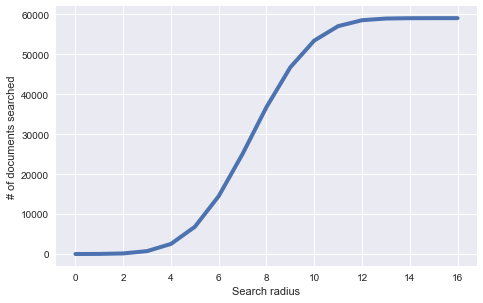

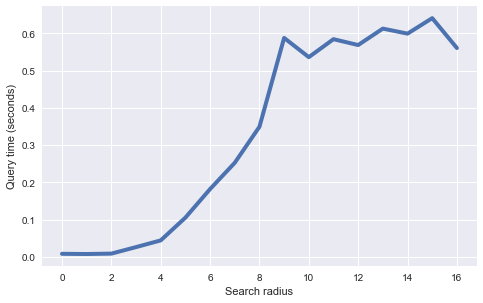

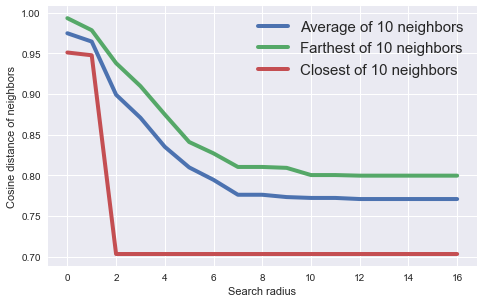

In [166]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Question 4
What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?

## Answer 4
2 as evident from the graph and the table outputs above!

## Question 5
Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?

## Answer 5
7, Again as evident from the above table output

Further we explore the effect of number of random vectors. 